In [1]:
# import basic necessities
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# retrieve data
from ucimlrepo import fetch_ucirepo, list_available_datasets

# import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# import train test
from sklearn.model_selection import train_test_split

sns.set_theme(style="darkgrid")

In [2]:
import sys
sys.path.insert(0, '../')

from util import calculate_disparate_impact

## Data Processing

In [3]:
adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets
adults_df_raw = pd.concat([X,y], axis=1)
adults_df = adults_df_raw.copy()

In [4]:
# encode output variable to binary
adults_df['income'] = adults_df['income'].apply(lambda x: 1 if '<' in x else 0)

In [5]:
# filter for only US entries
adults_df = adults_df[adults_df['native-country']=='United-States']

## Missingness

## EDA

### Basic Descriptive Statistics

In [60]:
adult.metadata.abstract

'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. '

In [61]:
adult.metadata.repository_url

'https://archive.ics.uci.edu/dataset/2/adult'

In [62]:
print(adult.metadata.additional_info.summary)

Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

Prediction task is to determine whether a person makes over 50K a year.



In [63]:
adults_df.shape

(43832, 15)

In [64]:
adults_df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income             int64
dtype: object

In [65]:
adults_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
count,43832.000000,4.383200e+04,43832.000000,43832.000000,43832.000000,43832.000000,43832.000000
mean,38.698690,1.871419e+05,10.168667,1089.626529,88.789743,40.440774,0.756023
std,13.795294,1.051913e+05,2.393353,7455.791326,405.539243,12.471352,0.429484
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.156770e+05,9.000000,0.000000,0.000000,40.000000,1.000000
50%,37.000000,1.766720e+05,10.000000,0.000000,0.000000,40.000000,1.000000
75%,48.000000,2.344772e+05,12.000000,0.000000,0.000000,45.000000,1.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [66]:
adults_df.isna().sum()

age                 0
workclass         871
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        874
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country      0
income              0
dtype: int64

In [67]:
adults_df.isna().sum().sum()

1745

### Plots

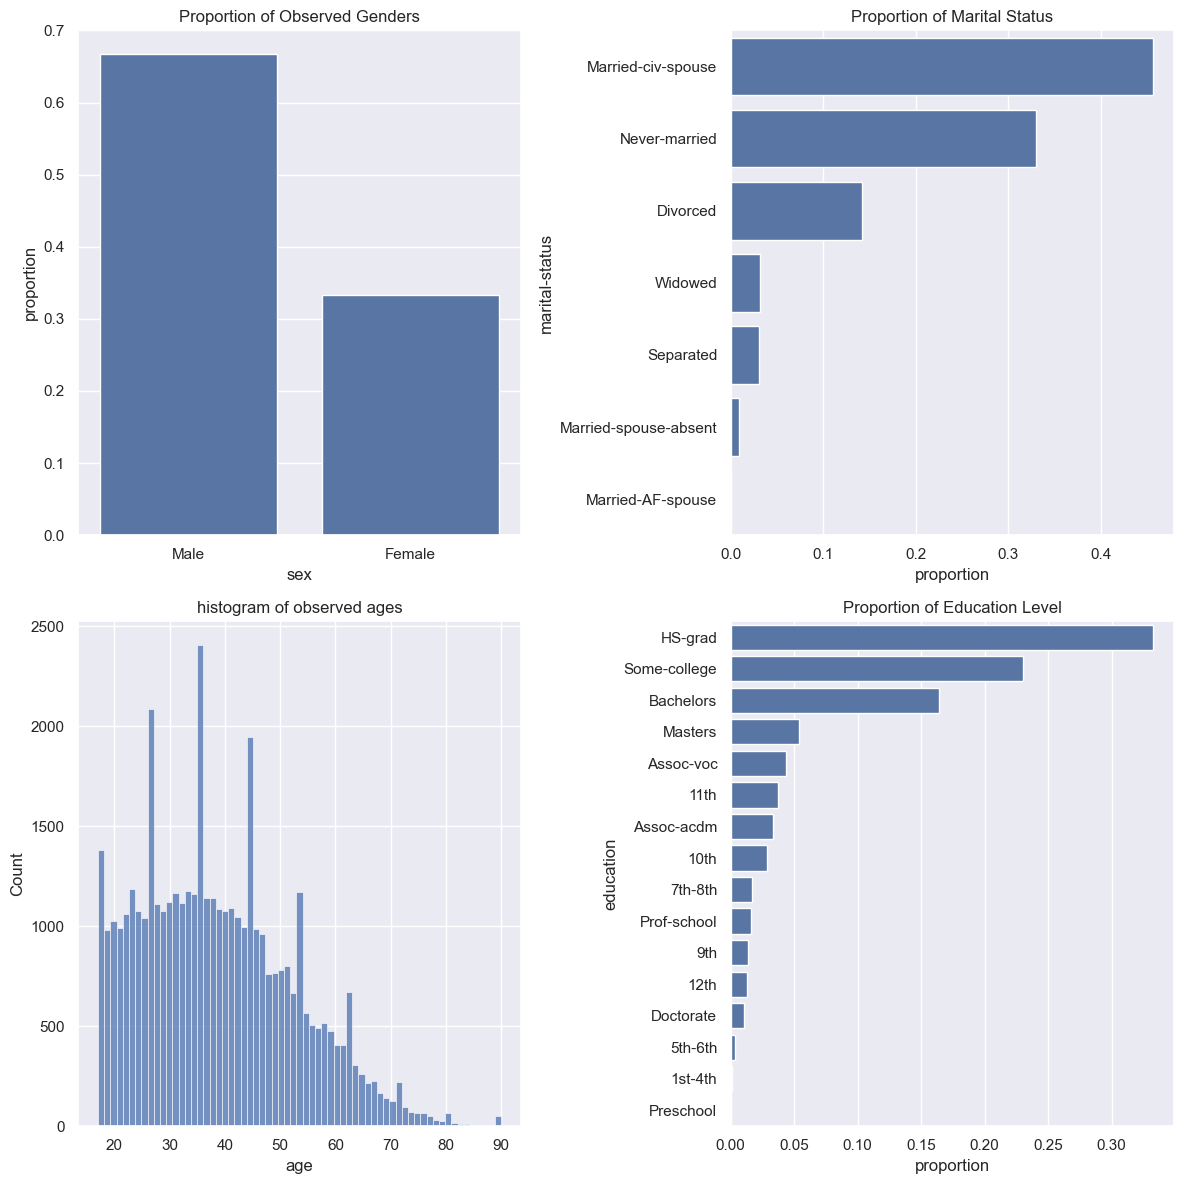

In [68]:
# Create 2x2 axis for plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# prop of sex plot
prop_sex = adults_df['sex'].value_counts(normalize=True)
prop_sex_df = pd.DataFrame({'sex': prop_sex.index, 'proportion': prop_sex.values})
sns.barplot(data=prop_sex_df, x='sex', y='proportion', ax=axes[0,0])
axes[0, 0].set_title("Proportion of Observed Genders")

# prop of marital status plot
prop_marital = adults_df['marital-status'].value_counts(normalize=True)
prop_marital_df = pd.DataFrame({'marital-status': prop_marital.index, 'proportion': prop_marital.values})
sns.barplot(data=prop_marital_df, y='marital-status', x='proportion', ax=axes[0,1])
axes[0, 1].set_title("Proportion of Marital Status")

# prop of education level plot
prop_education = adults_df['education'].value_counts(normalize=True)
prop_education_df = pd.DataFrame({'education': prop_education.index, 'proportion': prop_education.values})
sns.barplot(data=prop_education_df, y='education', x='proportion', ax=axes[1,1])
axes[1,1].set_title("Proportion of Education Level")

# age plot
sns.histplot(adults_df['age'], ax=axes[1,0])
axes[1,0].set_title('histogram of observed ages')

# Show the plot
plt.tight_layout()
plt.show()

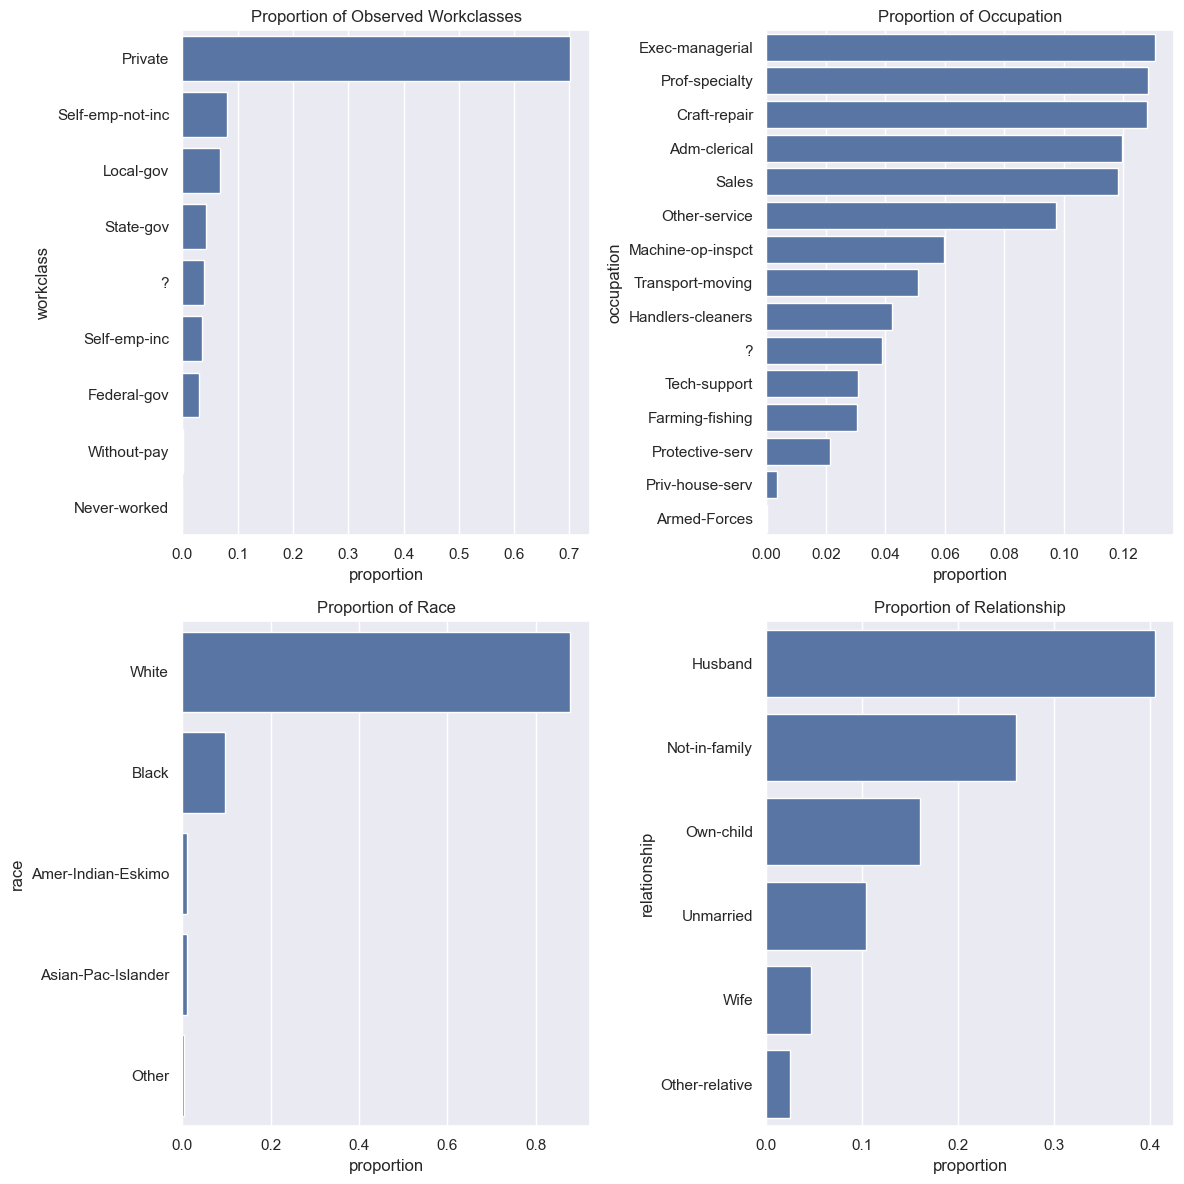

In [69]:
# Create 2x2 axis for plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# prop of work class plot
prop_class = adults_df['workclass'].value_counts(normalize=True)
prop_class_df = pd.DataFrame({'workclass': prop_class.index, 'proportion': prop_class.values})
sns.barplot(data=prop_class_df, y='workclass', x='proportion', ax=axes[0,0])
axes[0, 0].set_title("Proportion of Observed Workclasses")

# prop of occupation plot
prop_occupation = adults_df['occupation'].value_counts(normalize=True)
prop_occupation_df = pd.DataFrame({'occupation': prop_occupation.index, 'proportion': prop_occupation.values})
sns.barplot(data=prop_occupation_df, y='occupation', x='proportion', ax=axes[0,1])
axes[0, 1].set_title("Proportion of Occupation")

# prop of relationship plot
prop_relationship = adults_df['relationship'].value_counts(normalize=True)
prop_relationship_df = pd.DataFrame({'relationship': prop_relationship.index, 'proportion': prop_relationship.values})
sns.barplot(data=prop_relationship_df, y='relationship', x='proportion', ax=axes[1,1])
axes[1,1].set_title("Proportion of Relationship")

# prop of race plot
prop_race = adults_df['race'].value_counts(normalize=True)
prop_race_df = pd.DataFrame({'race': prop_race.index, 'proportion': prop_race.values})
sns.barplot(data=prop_race_df, y='race', x='proportion', ax=axes[1,0])
axes[1,0].set_title("Proportion of Race")

# Show the plot
plt.tight_layout()
plt.show()

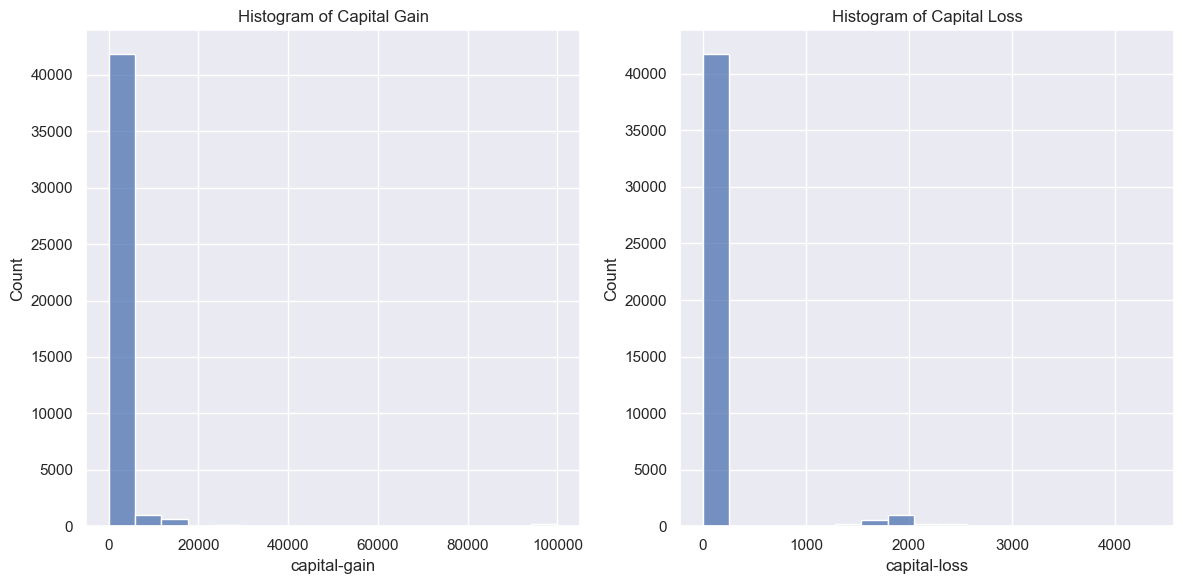

In [70]:
# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first histogram on the first subplot
sns.histplot(adults_df['capital-gain'], ax=axes[0])
axes[0].set_title("Histogram of Capital Gain")
# Add any other customizations like axes[0].set_xlabel(), axes[0].set_ylabel(), etc.

# Plot the second histogram on the second subplot
sns.histplot(adults_df['capital-loss'], ax=axes[1])
axes[1].set_title("Histogram of Capital Loss")
# Similarly, customize the second subplot as needed

# Show the plot
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()

## Naive Model Selection

In [6]:
# OHE relevant columns
categorical_columns = ['workclass','education-num', 'marital-status', 'occupation', 'relationship', 'race','sex']
adults_df_input = pd.get_dummies(adults_df.copy().drop(columns=['education', 'native-country']), columns = categorical_columns)

In [7]:
# split into input/output variables
X = adults_df_input.drop(columns=['income'])
y = adults_df_input['income']

In [8]:
# train test split, seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Model Building

In [74]:
# Settings to test
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Number of trees in the forest
    'max_depth': [10, 20, 30, 40, 50],    # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required at a leaf node
    'criterion': ['gini', 'entropy']            # The function to measure the quality of a split
}

rfc = RandomForestClassifier()
clf = GridSearchCV(rfc,param_grid, n_jobs=4)
clf.fit(X_train, y_train)

/opt/anaconda3/envs/biased_gs/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400]})

In [75]:
best_parameters = clf.best_params_
best_score = clf.best_score_
best_model = clf.best_estimator_

In [76]:
import joblib

In [77]:
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

In [79]:
best_parameters

{'criterion': 'entropy',
 'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 400}

In [81]:
best_score

0.8634183973900866

In [82]:
best_model

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=400)

In [10]:
temp = pd.concat([X_train,y_train], axis=1)

In [11]:
temp

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,income
41211,42,180985,0,0,52,False,False,False,False,True,...,False,False,False,False,False,False,True,False,True,1
5248,29,164607,0,0,40,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,1
11611,36,226918,0,0,48,False,False,False,False,True,...,False,False,False,False,True,False,False,False,True,1
21459,26,113571,0,0,70,False,False,False,False,True,...,False,False,False,False,False,False,True,False,True,1
5769,48,498325,0,0,50,False,False,False,False,True,...,False,False,False,False,False,False,True,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7010,37,190964,0,0,40,False,False,False,False,True,...,False,False,False,False,False,False,True,False,True,1
12607,17,285169,0,0,40,False,False,False,False,True,...,False,False,False,False,False,False,True,True,False,1
42515,25,104614,0,0,25,False,False,False,False,True,...,True,False,False,False,False,False,True,True,False,1
956,44,398473,0,0,70,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,0


In [12]:
calculate_disparate_impact(temp, 'income', 'sex_Male', True, False)

1.2847955407896374

## Model Evaluation

## Bias Aware Model Selection

## Comparison

## Conclusion